データセットを置く場所を指定

In [1]:
data_dir = 'data_paris6k'

Paris Datasetをダウンロード

In [2]:
import os
import shutil
import sys
import tarfile
import tempfile
import urllib.request

tmp_dir = tempfile.mkdtemp()
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

dirs_and_urls = [
    (tmp_dir, 'http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_1.tgz'),
    (tmp_dir, 'http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_2.tgz'),
    (tmp_dir, 'http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_120310.tgz'),
    (data_dir, 'http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/corrupt.txt')
]

def reporthook(count, block_size, total_size):
    progress = min((count * block_size / total_size), 1) * 100
    sys.stdout.write('\r{:.1f}%'.format(progress))
    sys.stdout.flush()

for _dir, url in dirs_and_urls:
    filepath = os.path.join(_dir, url.split('/')[-1])
    if not os.path.exists(filepath):
        print('Download: {}'.format(url))
        urllib.request.urlretrieve(url, filepath, reporthook=reporthook)
        print('\r')

for filename in os.listdir(tmp_dir):
    if not filename.endswith('.tgz'):
        continue
    src_path = os.path.join(tmp_dir, filename)
    with tarfile.open(src_path) as tar:
        tar.extractall(data_dir)
        
shutil.rmtree(tmp_dir)
print('Finished')

Download: http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_1.tgz
100.0%
Download: http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_2.tgz
100.0%
Download: http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_120310.tgz
100.0%
Finished


データセットからデータを読み込む準備

In [3]:
from glob import glob
import os

import skimage.io
import skimage.transform

corrupts = set()
with open(os.path.join(data_dir, 'corrupt.txt')) as f:
    for line in f:
        name = os.path.splitext(line.split('/')[-1])[0]
        corrupts.add(name)
        
def get_landmarks():
    return os.listdir(os.path.join(data_dir, 'paris'))

def iter_filepaths(groundtruth, landmarks):
    for landmark in landmarks:
        names = set()
        pattern = os.path.join(data_dir, '{}_[1-5]_{}.txt'.format(landmark, groundtruth))
        for filepath in glob(pattern):
            with open(filepath) as f:
                for line in f:
                    names.add(line.strip())
        names -= corrupts
        for name in sorted(names):
            pattern = os.path.join(data_dir, 'paris', '*', '{}.jpg'.format(name))
            for filepath in glob(pattern):
                yield landmark, filepath

def iter_data(groundtruth='ok', landmarks=get_landmarks(), rescale_width=None):
    for landmark, filepath in iter_filepaths(groundtruth, landmarks):
        data = skimage.io.imread(filepath)
        if isinstance(rescale_width, int):
            data = skimage.transform.rescale(data, rescale_width / data.shape[1])
        yield landmark, data

データの中身を表示

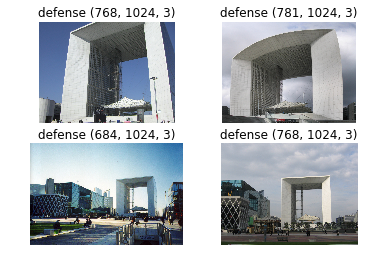

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, (label, data) in enumerate(iter_data()):
    if i >= 4:
        break
    plt.subplot(2, 2, i + 1)
    plt.imshow(data)
    plt.title('{} {}'. format(label, data.shape))
    plt.axis('off')

全データのラベルとHOG特徴量を取得 （時間かかります）

In [5]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog

def get_descriptors(data):
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (3, 3)
    feature_vector = hog(rgb2gray(data), orientations, pixels_per_cell, cells_per_block)
    return feature_vector.reshape(-1, np.multiply(*cells_per_block) * orientations)

labels, data_descriptors = zip(*((label, get_descriptors(data)) for label, data in iter_data(rescale_width=256)))
labels, data_descriptors = np.array(labels), np.array(data_descriptors)

訓練とテストに使うデータをそれぞれ準備

In [6]:
from sklearn.cross_validation import StratifiedKFold

train_indices, test_indices = list(StratifiedKFold(labels, n_folds=2, random_state=0))[0]

codebookを準備 （時間かかります）

In [7]:
from sklearn.cluster import MiniBatchKMeans

np.random.seed(0)

codebook_size = 1000

descriptors = np.vstack(data_descriptors[train_indices])
indices = np.random.choice(np.arange(len(descriptors)), size=500000, replace=False)
kmeans = MiniBatchKMeans(n_clusters=codebook_size, batch_size=1000, n_init=10, random_state=0)
kmeans.fit(descriptors[indices].astype(float))
del descriptors, indices

全データをBoVWに変換

In [8]:
def get_feature(descriptors):
    feature = np.zeros(codebook_size)
    for index in kmeans.predict(descriptors.astype(float)):
        feature[index] += 1
    return feature / np.sum(feature)

X = np.array([get_feature(descriptors) for descriptors in data_descriptors])

訓練とテスト

In [9]:
%%capture --no-stdout
from sklearn import metrics
from sklearn.svm import SVC

clf = SVC()
clf.fit(X[train_indices], labels[train_indices])

y_pred = clf.predict(X[test_indices])
print(metrics.classification_report(labels[test_indices], y_pred))
print(metrics.confusion_matrix(labels[test_indices], y_pred))

             precision    recall  f1-score   support

    defense       0.00      0.00      0.00        59
     eiffel       0.16      1.00      0.28       145
  invalides       0.00      0.00      0.00        99
     louvre       0.00      0.00      0.00        76
moulinrouge       0.00      0.00      0.00       119
museedorsay       0.00      0.00      0.00        36
  notredame       0.00      0.00      0.00        60
   pantheon       0.00      0.00      0.00        63
   pompidou       0.00      0.00      0.00        26
 sacrecoeur       0.00      0.00      0.00        75
   triomphe       0.00      0.00      0.00       141

avg / total       0.03      0.16      0.04       899

[[  0  59   0   0   0   0   0   0   0   0   0]
 [  0 145   0   0   0   0   0   0   0   0   0]
 [  0  99   0   0   0   0   0   0   0   0   0]
 [  0  76   0   0   0   0   0   0   0   0   0]
 [  0 119   0   0   0   0   0   0   0   0   0]
 [  0  36   0   0   0   0   0   0   0   0   0]
 [  0  60   0   0   0   0 

グリッドサーチでハイパーパラメータをチューニング

In [10]:
from sklearn import grid_search

params = {
    'gamma': [10 ** i for i in range(-3, 4)]
}
clf = grid_search.GridSearchCV(SVC(), params)
clf.fit(X[train_indices], labels[train_indices])

y_pred = clf.predict(X[test_indices])
print(metrics.classification_report(labels[test_indices], y_pred))
print(metrics.confusion_matrix(labels[test_indices], y_pred))

             precision    recall  f1-score   support

    defense       0.90      0.59      0.71        59
     eiffel       0.50      0.81      0.62       145
  invalides       0.58      0.38      0.46        99
     louvre       0.81      0.63      0.71        76
moulinrouge       0.92      0.85      0.88       119
museedorsay       1.00      0.81      0.89        36
  notredame       0.92      0.57      0.70        60
   pantheon       0.81      0.70      0.75        63
   pompidou       1.00      0.65      0.79        26
 sacrecoeur       0.56      0.59      0.57        75
   triomphe       0.67      0.84      0.75       141

avg / total       0.73      0.70      0.70       899

[[ 35   7   0   3   1   0   0   1   0   0  12]
 [  1 117   1   1   2   0   0   3   0   3  17]
 [  1  38  38   2   1   0   0   1   0  10   8]
 [  1  15   3  48   1   0   1   0   0   2   5]
 [  0  10   3   0 101   0   1   0   0   3   1]
 [  0   2   0   0   1  29   0   1   0   2   1]
 [  0   5   3   3   0   0 

予測結果を表示

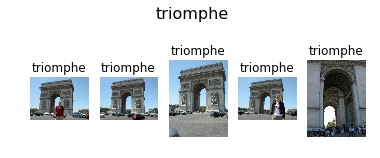

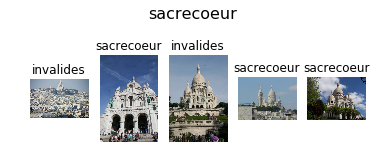

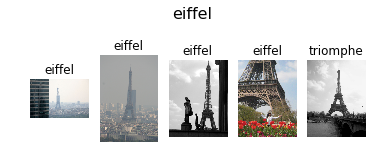

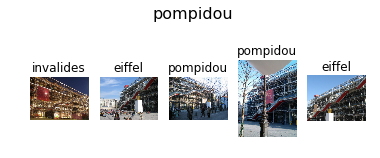

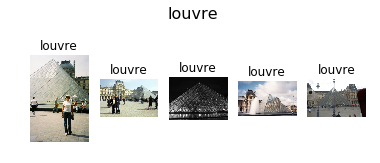

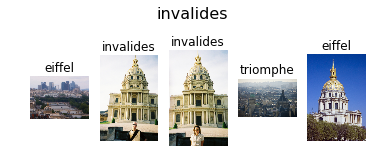

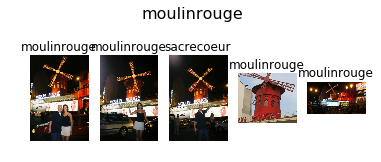

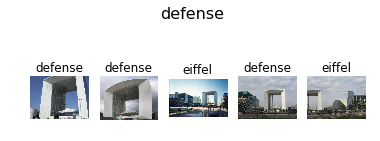

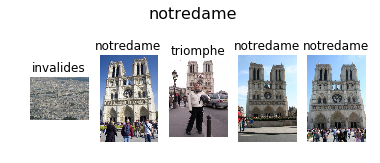

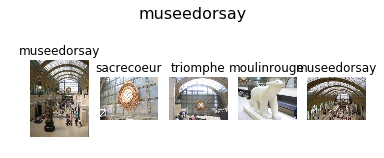

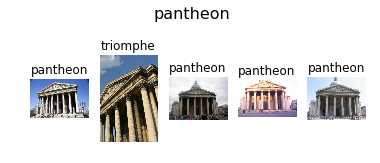

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

label_images = {label: [] for label in set(labels)}
for i ,(label, filepath) in enumerate(iter_filepaths(groundtruth='ok', landmarks=get_landmarks())):
    if all(len(images) >= 5 for images in label_images.values()):
        break
    if len(label_images[label]) >= 5:
        continue
    if i not in test_indices: 
        continue
    data = skimage.io.imread(filepath)
    data = skimage.transform.rescale(data, 256 / data.shape[1])
    x = get_feature(data_descriptors[i])
    y_pred = clf.predict([x])[0]
    label_images[label].append((y_pred, data))
    
for label, images in label_images.items():
    for i, (y_pred, data) in enumerate(images):
        if i >= 5:
            continue
        plt.subplot(1, 5, i + 1)
        plt.imshow(data)
        plt.title('{}'. format(y_pred))
        plt.axis('off')
    plt.suptitle('{}'.format(label), fontsize=16)
    plt.subplots_adjust(top=1.2)
    plt.show()
    
del label_images